In [1]:
using Pkg

Pkg.add(["CSV", "DataFrames", "Statistics", "ScikitLearn", "ScikitLearnBase", "Flux", "StatsBase", "Distributions", "Random", "Dates", "ProgressMeter", "Plots", "PyCall", "XLSX"])

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


In [2]:
using CSV
using DataFrames
using Statistics
using ScikitLearn
using ScikitLearn: inverse_transform
using ScikitLearnBase: transform, fit_transform!
using Flux
using Flux.Optimise: update!
using Flux.Losses: mse
using StatsBase
using Distributed
using Distributions
using Random
using Dates
using ProgressMeter
using Plots
using PyCall
using SharedArrays
using XLSX

# Initialize parallel workers if not already running
if nprocs() == 1
    # Use all available cores for parallel processing
    addprocs(Sys.CPU_THREADS - 1)
    println("Started $(nprocs()-1) worker processes")
end

# Importar funciones específicas de ScikitLearn
@sk_import preprocessing: (MinMaxScaler, StandardScaler)
@sk_import metrics: (mean_absolute_error, mean_squared_error, r2_score)

# Define configuration and paths
function findDataPath()
    possiblePaths = [
        joinpath(pwd(), "data", "subjects"),
        joinpath(dirname(pwd()), "data", "subjects"),
        joinpath(dirname(dirname(pwd())), "data", "subjects")
    ]
    
    for path in possiblePaths
        if isdir(path)
            println("Found data directory: $path")
            return path
        end
    end
    
    # Create a directory
    println("No data directory found. Creating one...")
    path = joinpath(pwd(), "data", "subjects")
    mkpath(path)
    return path
end

# Global configuration
CONFIG = Dict(
    "batchSize" => 128,
    "windowHours" => 2,
    "capNormal" => 30,
    "capBg" => 300,
    "capIob" => 5,
    "capCarb" => 150,
    "dataPath" => findDataPath(),
    "juliaSeed" => 42
)

Random.seed!(CONFIG["juliaSeed"])

# Make CONFIG available to all workers
@everywhere CONFIG_GLOBAL = $CONFIG

Started 4 worker processes
Found data directory: /Users/tomasshiao/Desktop/FIUBA/TPP/DL_Models/data/subjects


In [3]:
# First, define the module code as a string that we'll evaluate on all workers
module_code = """
module DistributedFunctions
    using Dates, DataFrames, Statistics, XLSX, ProgressMeter

    # Export these functions to be used outside the module
    export getCgmWindow, calculateIob, processSubject

    function getCgmWindow(bolusTime, cgmDf, windowHours)
        windowStart = bolusTime - Dates.Hour(windowHours)
        window = filter(row -> windowStart <= row.date <= bolusTime, cgmDf)
        sort!(window, :date)
        
        if nrow(window) >= 24
            lastValues = window[end-23:end, :"mg/dl"]
            return convert(Vector{Float64}, lastValues)
        else
            return nothing
        end
    end

    function calculateIob(bolusTime, basalDf, halfLifeHours=4)
        if basalDf === nothing || nrow(basalDf) == 0
            return 0.0
        end
        
        iob = 0.0
        for row in eachrow(basalDf)
            startTime = row.date
            durationHours = row.duration / (1000 * 3600)
            endTime = startTime + Dates.Second(round(Int, durationHours * 3600))
            rate = ismissing(row.rate) ? 0.9 : min(row.rate, 2.0)
            
            if startTime <= bolusTime <= endTime
                timeSinceStart = (bolusTime - startTime).value / 1000 / 3600  # en horas
                remaining = rate * (1 - (timeSinceStart / halfLifeHours))
                iob += max(0, remaining)
            end
        end
        
        return min(iob, 5.0)
    end

    function processSubject(subjectPath, idx, config)
        startTime = time()

        cgmDf = DataFrame()
        bolusDf = DataFrame()
        basalDf = DataFrame()

        try
            # En Julia necesitamos XLSX.jl para leer archivos Excel
            cgmDf = DataFrame(XLSX.readtable(subjectPath, "CGM"))
            bolusDf = DataFrame(XLSX.readtable(subjectPath, "Bolus"))
            
            try
                basalDf = DataFrame(XLSX.readtable(subjectPath, "Basal"))
            catch e
                basalDf = nothing
            end
        catch e
            println("Error al cargar \$(basename(subjectPath)): \$e")
            return Dict[]
        end

        # Convertir columnas de fecha a DateTime
        cgmDf.date = DateTime.(cgmDf.date)
        sort!(cgmDf, :date)
        bolusDf.date = DateTime.(bolusDf.date)
        
        if basalDf !== nothing
            basalDf.date = DateTime.(basalDf.date)
        end

        # Calcular medianas de entradas de carbohidratos para valores no cero
        nonZeroCarbs = filter(row -> !ismissing(row.carbInput) && row.carbInput > 0, bolusDf).carbInput
        carbMedian = length(nonZeroCarbs) > 0 ? median(nonZeroCarbs) : 10.0

        # Calcular valores IOB
        iobValues = [calculateIob(row.date, basalDf) for row in eachrow(bolusDf)]
        nonZeroIob = filter(iob -> iob > 0, iobValues)
        iobMedian = length(nonZeroIob) > 0 ? median(nonZeroIob) : 0.5

        processedData = Dict[]
        p = Progress(nrow(bolusDf), desc="Procesando \$(basename(subjectPath))")
        
        for row in eachrow(bolusDf)
            bolusTime = row.date
            cgmWindow = getCgmWindow(bolusTime, cgmDf, config["windowHours"])
            
            if cgmWindow !== nothing
                iob = calculateIob(bolusTime, basalDf)
                iob = iob == 0 ? iobMedian : iob
                hourOfDay = Dates.hour(bolusTime) / 23.0
                bgInput = ismissing(row.bgInput) ? cgmWindow[end] : row.bgInput
                
                normal = ismissing(row.normal) ? 0.0 : row.normal
                normal = clamp(normal, 0, config["capNormal"])
                
                bgInput = max(bgInput, 50.0)
                isfCustom = normal <= 0 ? 50.0 : (bgInput - 100) / normal
                isfCustom = clamp(isfCustom, 10, 100)
                
                bgInput = clamp(bgInput, 0, config["capBg"])
                iob = clamp(iob, 0, config["capIob"])
                carbInput = ismissing(row.carbInput) ? 0.0 : row.carbInput
                carbInput = carbInput == 0 ? carbMedian : carbInput
                carbInput = clamp(carbInput, 0, config["capCarb"])
                
                features = Dict(
                    "subjectId" => idx,
                    "cgmWindow" => cgmWindow,
                    "carbInput" => carbInput,
                    "bgInput" => bgInput,
                    "insulinCarbRatio" => clamp(ismissing(row.insulinCarbRatio) ? 10.0 : row.insulinCarbRatio, 5, 20),
                    "insulinSensitivityFactor" => isfCustom,
                    "insulinOnBoard" => iob,
                    "hourOfDay" => hourOfDay,
                    "normal" => normal
                )
                push!(processedData, features)
            end
            
            next!(p)
        end

        elapsedTime = time() - startTime
        println("Procesado \$(basename(subjectPath)) (Sujeto \$(idx+1)) en \$(round(elapsedTime, digits=2)) segundos")
        return processedData
    end
end
"""

"module DistributedFunctions\n    using Dates, DataFrames, Statistics, XLSX, ProgressMeter\n\n    # Export these functions to be used outside the module\n    export getCgmWindow, calculateIob, processSubject\n\n    function getCgmWindow(bolusTime, cgmDf, windowHours)\n        w" ⋯ 4434 bytes ⋯ "eatures)\n            end\n            \n            next!(p)\n        end\n\n        elapsedTime = time() - startTime\n        println(\"Procesado \$(basename(subjectPath)) (Sujeto \$(idx+1)) en \$(round(elapsedTime, digits=2)) segundos\")\n        return processedData\n    end\nend\n"

In [4]:
# Load the module on the main process
include_string(Main, module_code)
using .DistributedFunctions

# Load the module on all workers
@everywhere begin
    using Dates, DataFrames, Statistics, XLSX, ProgressMeter
end

@everywhere module_code = $module_code
@everywhere include_string(Main, module_code)
@everywhere using .DistributedFunctions

In [5]:
"""
    getCgmWindow(bolusTime, cgmDf, windowHours=CONFIG["windowHours"])

Obtiene una ventana de datos CGM alrededor del tiempo del bolo de insulina.

# Argumentos
- `bolusTime::DateTime`: Tiempo del bolo de insulina.
- `cgmDf::DataFrame`: DataFrame con datos CGM.
- `windowHours::Int`: Tamaño de la ventana en horas.

# Retorno
- `Vector{Float64}`: Vector con los últimos 24 valores CGM o `nothing` si no hay suficientes datos.
"""
getCgmWindow

"""
    calculateIob(bolusTime, basalDf, halfLifeHours=4)

Calcula la insulina activa (IOB) en un momento dado.

# Argumentos
- `bolusTime::DateTime`: Tiempo para calcular IOB.
- `basalDf::Union{DataFrame, Nothing}`: DataFrame con datos de insulina basal.
- `halfLifeHours::Int`: Vida media de la insulina en horas.

# Retorno
- `Float64`: Cantidad de insulina activa.
"""
calculateIob

"""
    processSubject(subjectPath, idx, CONFIG)

Procesa los datos de un sujeto del estudio.

# Argumentos
- `subjectPath::String`: Ruta al archivo Excel con datos del sujeto.
- `idx::Int`: Índice/ID del sujeto.
- `CONFIG::Dict`: Configuración global.

# Retorno
- `Vector{Dict}`: Lista de diccionarios con características procesadas.
"""
processSubject

processSubject

In [6]:

"""
    processAndConvertToDataFrame(allProcessedData)

Convierte los datos procesados a un DataFrame.

# Argumentos
- `allProcessedData::Vector{Dict}`: Lista de diccionarios con características procesadas.

# Retorno
- `DataFrame`: DataFrame con todos los datos procesados.
"""
function processAndConvertToDataFrame(allProcessedData)
    if isempty(allProcessedData)
        error("No data processed. Check if the data directory exists and contains valid subject files.")
    end
    
    # Extraer las ventanas CGM para procesarlas por separado
    cgmData = [pop!(item, "cgmWindow") for item in allProcessedData]
    
    # Crear el dataframe con los demás datos
    dfProcessed = DataFrame(allProcessedData)
    
    # Procesar las ventanas CGM y crear columnas individuales
    cgmColumns = ["cgm_$i" for i in 0:23]
    
    if isempty(cgmData)
        error("No CGM data found in processed data")
    end
    
    cgmArrays = hcat(cgmData...)'
    
    # Crear un dataframe con las columnas CGM
    cgmDf = DataFrame(cgmArrays, cgmColumns)
    
    # Unir los dataframes
    return hcat(cgmDf, dfProcessed)
end

"""
    preprocessData(subjectFolder)

Preprocesa los datos de todos los sujetos para el entrenamiento del modelo.

# Argumentos
- `subjectFolder::String`: Ruta a la carpeta que contiene los archivos Excel de los sujetos.

# Retorno
- `DataFrame`: DataFrame con todos los datos procesados.
"""
function preprocessData(subjectFolder)
    startTime = time()
    
    subjectFiles = filter(f -> startswith(f, "Subject") && endswith(f, ".xlsx"), readdir(subjectFolder))
    println("\nArchivos de sujetos encontrados ($(length(subjectFiles))):")
    foreach(println, subjectFiles)

    # Process subjects in parallel
    results = @distributed (append!) for (idx, f) in collect(enumerate(subjectFiles))
        fullPath = joinpath(subjectFolder, f)
        println("Processing $fullPath")
        try
            processSubject(fullPath, idx, CONFIG_GLOBAL)
        catch e
            println("Error processing $fullPath: $e")
            Dict[]
        end
    end

    # Check if we have data
    if isempty(results)
        error("No se procesaron datos. Verifica los archivos de sujetos.")
    end

    # Convertir a DataFrame
    dfFinal = processAndConvertToDataFrame(results)
    
    println("Muestra de datos procesados combinados:")
    println(first(dfFinal, 5))
    println("Total de muestras: $(nrow(dfFinal))")

    # Aplicar transformaciones logarítmicas
    for col in ["normal", "carbInput", "insulinOnBoard", "bgInput"]
        dfFinal[!, col] = log1p.(dfFinal[!, col])
    end
    
    # Aplicar transformación logarítmica a las columnas CGM
    for col in ["cgm_$i" for i in 0:23]
        dfFinal[!, col] = log1p.(dfFinal[!, col])
    end
    
    # Eliminar filas con valores nulos
    dfFinal = dropmissing(dfFinal)
    println("Verificación de NaN en dfFinal:")
    println(sum(ismissing.(Matrix(dfFinal))))

    elapsedTime = time() - startTime
    println("Preprocesamiento completo en $(round(elapsedTime, digits=2)) segundos")
    return dfFinal
end

"""
    splitData(dfFinal)

Divide los datos en conjuntos de entrenamiento, validación y prueba, asegurando distribuciones similares.
Fuerza al Sujeto 49 a estar en el conjunto de prueba para evaluación y equilibra medias y desviaciones estándar.

# Argumentos
- `dfFinal::DataFrame`: DataFrame con todos los datos.

# Retorno
- `Tuple`: Tupla con datos divididos para entrenamiento, validación y prueba y los escaladores.
"""
function splitData(dfFinal)
    startTime = time()
    
    # Calcular la media y desviación estándar de dosis de insulina para cada sujeto
    gdf = groupby(dfFinal, :subjectId)
    subjectStats = combine(gdf, :normal => mean => :meanDose, :normal => std => :stdDose)
    subjectIds = unique(dfFinal.subjectId)

    # Ordenar sujetos por su dosis media de insulina
    sort!(subjectStats, :meanDose)
    sortedSubjects = subjectStats.subjectId

    nSubjects = length(sortedSubjects)

    # Apuntar a un split 80%-10%-10%
    trainSize = round(Int, 0.8 * nSubjects)  # 80% para entrenamiento
    valSize = round(Int, 0.1 * nSubjects)    # 10% para validación
    testSize = nSubjects - trainSize - valSize  # 10% para prueba

    # Forzar al Sujeto 49 a estar en el conjunto de prueba
    testSubjects = 49 in sortedSubjects ? [49] : Int[]
    remainingSubjects = filter(s -> s != 49, sortedSubjects)
    trainSubjects = Int[]
    valSubjects = Int[]

    # Asignar sujetos para minimizar diferencias en medias y desviaciones estándar
    remainingSubjectsList = collect(remainingSubjects)
    shuffle!(remainingSubjectsList)  # Mezclar para evitar sesgos en el orden de asignación

    for subject in remainingSubjectsList
        # Calcular medias y desviaciones actuales de cada conjunto
        trainMean = length(trainSubjects) > 0 ? mean(dfFinal[in.(dfFinal.subjectId, Ref(trainSubjects)), :normal]) : 0
        valMean = length(valSubjects) > 0 ? mean(dfFinal[in.(dfFinal.subjectId, Ref(valSubjects)), :normal]) : 0
        testMean = length(testSubjects) > 0 ? mean(dfFinal[in.(dfFinal.subjectId, Ref(testSubjects)), :normal]) : 0
        trainStd = length(trainSubjects) > 0 ? std(dfFinal[in.(dfFinal.subjectId, Ref(trainSubjects)), :normal]) : 0
        valStd = length(valSubjects) > 0 ? std(dfFinal[in.(dfFinal.subjectId, Ref(valSubjects)), :normal]) : 0
        testStd = length(testSubjects) > 0 ? std(dfFinal[in.(dfFinal.subjectId, Ref(testSubjects)), :normal]) : 0

        # Calcular las estadísticas si agregamos este sujeto a cada conjunto
        trainTemp = [trainSubjects; subject]
        valTemp = [valSubjects; subject]
        testTemp = [testSubjects; subject]

        trainMeanNew = mean(dfFinal[in.(dfFinal.subjectId, Ref(trainTemp)), :normal])
        valMeanNew = mean(dfFinal[in.(dfFinal.subjectId, Ref(valTemp)), :normal])
        testMeanNew = mean(dfFinal[in.(dfFinal.subjectId, Ref(testTemp)), :normal])
        trainStdNew = std(dfFinal[in.(dfFinal.subjectId, Ref(trainTemp)), :normal])
        valStdNew = std(dfFinal[in.(dfFinal.subjectId, Ref(valTemp)), :normal])
        testStdNew = std(dfFinal[in.(dfFinal.subjectId, Ref(testTemp)), :normal])

        # Calcular la media y la desviación estándar si agregamos a cada conjunto
        meansIfTrain = [trainMeanNew, valMean, testMean]
        meansIfVal = [trainMean, valMeanNew, testMean]
        meansIfTest = [trainMean, valMean, testMeanNew]
        stdsIfTrain = [trainStdNew, valStd, testStd]
        stdsIfVal = [trainStd, valStdNew, testStd]
        stdsIfTest = [trainStd, valStd, testStdNew]

        # Calcular el rango de medias y desviaciones (max - min) para cada opción
        rangeMeansIfTrain = all(m -> m != 0, meansIfTrain) ? maximum(meansIfTrain) - minimum(meansIfTrain) : Inf
        rangeMeansIfVal = all(m -> m != 0, meansIfVal) ? maximum(meansIfVal) - minimum(meansIfVal) : Inf
        rangeMeansIfTest = all(m -> m != 0, meansIfTest) ? maximum(meansIfTest) - minimum(meansIfTest) : Inf
        rangeStdsIfTrain = all(s -> s != 0, stdsIfTrain) ? maximum(stdsIfTrain) - minimum(stdsIfTrain) : Inf
        rangeStdsIfVal = all(s -> s != 0, stdsIfVal) ? maximum(stdsIfVal) - minimum(stdsIfVal) : Inf
        rangeStdsIfTest = all(s -> s != 0, stdsIfTest) ? maximum(stdsIfTest) - minimum(stdsIfTest) : Inf

        # Combinar diferencias de media y desviación (ponderadas igualmente)
        scoreIfTrain = rangeMeansIfTrain + rangeStdsIfTrain
        scoreIfVal = rangeMeansIfVal + rangeStdsIfVal
        scoreIfTest = rangeMeansIfTest + rangeStdsIfTest

        # Respetar los tamaños de split objetivo
        if length(trainSubjects) < trainSize && scoreIfTrain <= min(scoreIfVal, scoreIfTest)
            push!(trainSubjects, subject)
        elseif length(valSubjects) < valSize && scoreIfVal <= min(scoreIfTrain, scoreIfTest)
            push!(valSubjects, subject)
        elseif length(testSubjects) < testSize
            push!(testSubjects, subject)
        else
            # Si se exceden los tamaños, por defecto a entrenamiento
            push!(trainSubjects, subject)
        end
    end

    # Crear máscaras para dividir
    trainMask = in.(dfFinal.subjectId, Ref(trainSubjects))
    valMask = in.(dfFinal.subjectId, Ref(valSubjects))
    testMask = in.(dfFinal.subjectId, Ref(testSubjects))

    # Verificar distribuciones después de dividir
    yTrainTemp = dfFinal[trainMask, :normal]
    yValTemp = dfFinal[valMask, :normal]
    yTestTemp = dfFinal[testMask, :normal]
    println("Post-split Train y: mean = $(mean(yTrainTemp)), std = $(std(yTrainTemp))")
    println("Post-split Val y: mean = $(mean(yValTemp)), std = $(std(yValTemp))")
    println("Post-split Test y: mean = $(mean(yTestTemp)), std = $(std(yTestTemp))")

    # Inicializar escaladores
    scalerCgm = StandardScaler()
    scalerOther = StandardScaler()
    scalerY = StandardScaler()
    cgmColumns = ["cgm_$i" for i in 0:23]
    otherFeatures = ["carbInput", "bgInput", "insulinOnBoard", "insulinCarbRatio", 
                    "insulinSensitivityFactor", "hourOfDay"]

    # Escalar solo en datos de entrenamiento
    XCgmTrain = fit_transform!(scalerCgm, Matrix(dfFinal[trainMask, cgmColumns]))
    XCgmTrain = reshape(XCgmTrain, :, 24, 1)
    XCgmVal = ScikitLearn.transform(scalerCgm, Matrix(dfFinal[valMask, cgmColumns]))
    XCgmVal = reshape(XCgmVal, :, 24, 1)
    XCgmTest = ScikitLearn.transform(scalerCgm, Matrix(dfFinal[testMask, cgmColumns]))
    XCgmTest = reshape(XCgmTest, :, 24, 1)
    
    XOtherTrain = fit_transform!(scalerOther, Matrix(dfFinal[trainMask, otherFeatures]))
    XOtherVal = ScikitLearn.transform(scalerOther, Matrix(dfFinal[valMask, otherFeatures]))
    XOtherTest = ScikitLearn.transform(scalerOther, Matrix(dfFinal[testMask, otherFeatures]))
    
    yTrain = fit_transform!(scalerY, reshape(dfFinal[trainMask, :normal], :, 1))
    yTrain = vec(yTrain)
    yVal = ScikitLearn.transform(scalerY, reshape(dfFinal[valMask, :normal], :, 1))
    yVal = vec(yVal)
    yTest = ScikitLearn.transform(scalerY, reshape(dfFinal[testMask, :normal], :, 1))
    yTest = vec(yTest)

    XSubjectTrain = dfFinal[trainMask, :subjectId]
    XSubjectVal = dfFinal[valMask, :subjectId]
    XSubjectTest = dfFinal[testMask, :subjectId]
    subjectTest = XSubjectTest

    println("Entrenamiento CGM: $(size(XCgmTrain)), Validación CGM: $(size(XCgmVal)), Prueba CGM: $(size(XCgmTest))")
    println("Entrenamiento Otros: $(size(XOtherTrain)), Validación Otros: $(size(XOtherVal)), Prueba Otros: $(size(XOtherTest))")
    println("Entrenamiento Subject: $(size(XSubjectTrain)), Validación Subject: $(size(XSubjectVal)), Prueba Subject: $(size(XSubjectTest))")
    println("Sujetos de prueba: $testSubjects")

    elapsedTime = time() - startTime
    println("División de datos completa en $(round(elapsedTime, digits=2)) segundos")
    
    return (XCgmTrain, XCgmVal, XCgmTest,
            XOtherTrain, XOtherVal, XOtherTest,
            XSubjectTrain, XSubjectVal, XSubjectTest,
            yTrain, yVal, yTest, subjectTest,
            scalerCgm, scalerOther, scalerY)
end

"""
    ruleBasedPrediction(XOther, scalerOther, scalerY; targetBg=100)

Genera predicciones basadas en reglas médicas estándar.

# Argumentos
- `XOther::Matrix{Float64}`: Características adicionales normalizadas.
- `scalerOther::StandardScaler`: Scaler para desnormalizar características.
- `scalerY::StandardScaler`: Scaler para normalizar predicciones.
- `targetBg::Int=100`: Nivel objetivo de glucosa en sangre.

# Retorno
- `Vector{Float64}`: Vector con predicciones de dosis.
"""
function ruleBasedPrediction(XOther, scalerOther, scalerY; targetBg=100)
    startTime = time()
    
    XOtherNp = XOther
    inverseTransformed = ScikitLearn.inverse_transform(scalerOther, XOtherNp)
    
    carbInput = inverseTransformed[:, 1]
    bgInput = inverseTransformed[:, 2]
    icr = inverseTransformed[:, 4]
    isf = inverseTransformed[:, 5]
    
    # Reemplazar ceros con valores pequeños para evitar división por cero
    icr[icr .== 0] .= 1e-6
    isf[isf .== 0] .= 1e-6
    
    # Calcular componentes
    carbComponent = carbInput ./ icr
    bgComponent = (bgInput .- targetBg) ./ isf
    
    # Combinar y recortar predicciones
    prediction = carbComponent .+ bgComponent
    prediction = clamp.(prediction, 0, CONFIG["capNormal"])

    elapsedTime = time() - startTime
    println("Predicción basada en reglas completa en $(round(elapsedTime, digits=2)) segundos")
    return prediction
end

ruleBasedPrediction

In [7]:

"""
    struct MLPModel
        layers::Chain
        optimizer::Descent
        lossFn::Function
    end

Modelo de red neuronal implementado con Flux.

# Campos
- `layers::Chain`: Capas del modelo.
- `optimizer::Descent`: Optimizador.
- `lossFn::Function`: Función de pérdida.
"""
mutable struct MLPModel
    layers::Chain
    optimizer::Descent
    lossFn::Function
end

"""
    MLPModel(layerSizes::Vector{Int}, activation=relu; learningRate=0.001)

Inicializa un modelo MLP.

# Argumentos
- `layerSizes::Vector{Int}`: Tamaños de las capas.
- `activation::Function=relu`: Función de activación para capas ocultas.
- `learningRate::Float64=0.001`: Tasa de aprendizaje.

# Retorno
- `MLPModel`: Modelo MLP inicializado.
"""
function MLPModel(layerSizes::Vector{Int}, activation=relu; learningRate=0.001)
    layers = []
    
    for i in 1:length(layerSizes)-2
        push!(layers, Dense(layerSizes[i], layerSizes[i+1], activation))
    end
    
    # Capa de salida (sin activación)
    push!(layers, Dense(layerSizes[end-1], layerSizes[end]))
    
    return MLPModel(
        Chain(layers...),
        Descent(learningRate),
        (x, y) -> Flux.mse(vec(x), y)  # MSE como función de pérdida
    )
end

"""
    forward(model::MLPModel, XCgm::Array{Float64}, XOther::Matrix{Float64})

Realiza una pasada hacia adelante a través del modelo.

# Argumentos
- `model::MLPModel`: Modelo MLP.
- `XCgm::Array{Float64}`: Datos CGM.
- `XOther::Matrix{Float64}`: Otras características.

# Retorno
- `Vector{Float64}`: Salida del modelo.
"""
function forward(model::MLPModel, XCgm::Array{Float64}, XOther::Matrix{Float64})
    # Aplanar datos CGM
    batchSize = size(XCgm, 1)
    XCgmFlat = reshape(XCgm, batchSize, :)
    
    # Concatenar entradas
    x = hcat(XCgmFlat, XOther)
    
    # Pasada hacia adelante
    return vec(model.layers(x'))
end

"""
    loss(model::MLPModel, XCgm::Array{Float64}, XOther::Matrix{Float64}, y::Vector{Float64})

Calcula la función de pérdida.

# Argumentos
- `model::MLPModel`: Modelo MLP.
- `XCgm::Array{Float64}`: Datos CGM.
- `XOther::Matrix{Float64}`: Otras características.
- `y::Vector{Float64}`: Valores objetivo.

# Retorno
- `Float64`: Valor de la pérdida.
"""
function loss(model::MLPModel, XCgm::Array{Float64}, XOther::Matrix{Float64}, y::Vector{Float64})
    ŷ = forward(model, XCgm, XOther)
    return model.lossFn(ŷ, y)
end

"""
    gradientStep!(model::MLPModel, XCgm::Array{Float64}, XOther::Matrix{Float64}, y::Vector{Float64})

Realiza un paso de gradiente para actualizar los parámetros del modelo.

# Argumentos
- `model::MLPModel`: Modelo MLP.
- `XCgm::Array{Float64}`: Datos CGM.
- `XOther::Matrix{Float64}`: Otras características.
- `y::Vector{Float64}`: Valores objetivo.

# Retorno
- `Float64`: Valor de la pérdida.
"""
function gradientStep!(model::MLPModel, XCgm::Array{Float64}, XOther::Matrix{Float64}, y::Vector{Float64})
    # Create the optimizer state only once
    optim_state = Flux.setup(model.optimizer, model.layers)
    
    # Compute gradients with the new API
    loss_value, grads = Flux.withgradient(model.layers) do m
        ŷ = forward(MLPModel(m, model.optimizer, model.lossFn), XCgm, XOther)
        model.lossFn(ŷ, y)
    end
    
    # Update parameters with the new API
    Flux.update!(optim_state, model.layers, grads[1])
    
    return loss_value
end

"""
    train!(model::MLPModel, XCgmTrain::Array{Float64}, XOtherTrain::Matrix{Float64}, yTrain::Vector{Float64},
           XCgmVal::Array{Float64}, XOtherVal::Matrix{Float64}, yVal::Vector{Float64};
           batchSize::Int=CONFIG["batchSize"], epochs::Int=100, patience::Int=10)

Entrena el modelo con early stopping.

# Argumentos
- `model::MLPModel`: Modelo MLP.
- `XCgmTrain::Array{Float64}`: Datos CGM de entrenamiento.
- `XOtherTrain::Matrix{Float64}`: Otras características de entrenamiento.
- `yTrain::Vector{Float64}`: Valores objetivo de entrenamiento.
- `XCgmVal::Array{Float64}`: Datos CGM de validación.
- `XOtherVal::Matrix{Float64}`: Otras características de validación.
- `yVal::Vector{Float64}`: Valores objetivo de validación.
- `batchSize::Int=CONFIG["batchSize"]`: Tamaño del lote para entrenar.
- `epochs::Int=100`: Número de épocas.
- `patience::Int=10`: Paciencia para early stopping.

# Retorno
- `Tuple`: Pérdidas de entrenamiento, pérdidas de validación y mejor época.
"""
function train!(model::MLPModel, XCgmTrain::Array{Float64}, XOtherTrain::Matrix{Float64}, yTrain::Vector{Float64},  XCgmVal::Array{Float64}, XOtherVal::Matrix{Float64}, yVal::Vector{Float64}; batchSize::Int=CONFIG["batchSize"], epochs::Int=100, patience::Int=10)

    nSamples = size(XCgmTrain, 1)
    nBatches = ceil(Int, nSamples / batchSize)

    # Create optimizer state
    optim_state = Flux.setup(model.optimizer, model.layers)

    # Variables para entrenamiento
    bestValLoss = Inf
    bestParams = deepcopy(Flux.trainable(model.layers))
    patienceCounter = 0
    trainLosses = Float64[]
    valLosses = Float64[]
    bestEpoch = 0

    for epoch in 1:epochs
        # Barajar datos
        indices = shuffle(1:nSamples)
        XCgmTrainShuf = XCgmTrain[indices, :, :]
        XOtherTrainShuf = XOtherTrain[indices, :]
        yTrainShuf = yTrain[indices]

        epochLoss = 0.0
        # Entrenar por lotes
        for batchIdx in 1:nBatches
            startIdx = (batchIdx - 1) * batchSize + 1
            endIdx = min(batchIdx * batchSize, nSamples)
            
            batchCgm = XCgmTrainShuf[startIdx:endIdx, :, :]
            batchOther = XOtherTrainShuf[startIdx:endIdx, :]
            batchY = yTrainShuf[startIdx:endIdx]
            
            # Compute gradients and update parameters
            loss_value, grads = Flux.withgradient(model.layers) do m
                ŷ = forward(MLPModel(m, model.optimizer, model.lossFn), batchCgm, batchOther)
                model.lossFn(ŷ, batchY)
            end
            
            Flux.update!(optim_state, model.layers, grads[1])
            
            epochLoss += loss_value * (endIdx - startIdx + 1)
        end

        # Calcular pérdida promedio
        avgTrainLoss = epochLoss / nSamples
        push!(trainLosses, avgTrainLoss)

        # Evaluar en conjunto de validación
        valLoss = loss(model, XCgmVal, XOtherVal, yVal)
        push!(valLosses, valLoss)

        # Imprimir progreso
        if epoch % 10 == 0 || epoch == epochs
            println("Época $epoch: Pérdida entrenamiento = $(round(avgTrainLoss, digits=4)), Pérdida validación = $(round(valLoss, digits=4))")
        end

        # Early stopping
        if valLoss < bestValLoss
            bestValLoss = valLoss
            bestParams = deepcopy(Flux.trainable(model.layers))
            bestEpoch = epoch
            patienceCounter = 0
        else
            patienceCounter += 1
            if patienceCounter >= patience
                println("Early stopping en época $epoch")
                Flux.loadmodel!(model.layers, bestParams)
                break
            end
        end
    end

    # Restaurar mejores parámetros
    Flux.loadmodel!(model.layers, bestParams)
    return trainLosses, valLosses, bestEpoch
end

"""
    predict(model::MLPModel, XCgm::Array{Float64}, XOther::Matrix{Float64})

Genera predicciones para nuevos datos.

# Argumentos
- `model::MLPModel`: Modelo MLP.
- `XCgm::Array{Float64}`: Datos CGM.
- `XOther::Matrix{Float64}`: Otras características.

# Retorno
- `Vector{Float64}`: Predicciones.
"""
function predict(model::MLPModel, XCgm::Array{Float64}, XOther::Matrix{Float64})
    return forward(model, XCgm, XOther)
end

"""
    generateDenormalizedPredictions(model::MLPModel, XCgm::Array{Float64}, XOther::Matrix{Float64}, scalerY)

Genera predicciones desnormalizadas usando el modelo MLP.

# Argumentos
- `model::MLPModel`: Modelo entrenado.
- `XCgm::Array{Float64}`: Datos CGM normalizados.
- `XOther::Matrix{Float64}`: Otras características normalizadas.
- `scalerY`: Scaler para desnormalizar las predicciones.

# Retorno
- `Vector{Float64}`: Predicciones desnormalizadas.
"""
function generateDenormalizedPredictions(model::MLPModel, XCgm::Array{Float64}, XOther::Matrix{Float64}, scalerY)
    # Generar predicciones normalizadas
    predictions = predict(model, XCgm, XOther)
    
    # Desnormalizar predicciones
    denormalizedPredictions = ScikitLearn.inverse_transform(scalerY, reshape(predictions, :, 1))
    
    return vec(denormalizedPredictions)
end

"""
    trainParallelModels(XCgmTrain, XOtherTrain, yTrain, XCgmVal, XOtherVal, yVal, nModels=4)

Entrena múltiples modelos en paralelo.

# Argumentos
- `XCgmTrain::Array{Float64}`: Datos CGM de entrenamiento.
- `XOtherTrain::Matrix{Float64}`: Otras características de entrenamiento.
- `yTrain::Vector{Float64}`: Valores objetivo de entrenamiento.
- `XCgmVal::Array{Float64}`: Datos CGM de validación.
- `XOtherVal::Matrix{Float64}`: Otras características de validación.
- `yVal::Vector{Float64}`: Valores objetivo de validación.
- `nModels::Int=4`: Número de modelos a entrenar en paralelo.

# Retorno
- `Vector{MLPModel}`: Modelos entrenados.
"""
function trainParallelModels(XCgmTrain, XOtherTrain, yTrain, XCgmVal, XOtherVal, yVal, nModels=4)
    # Split the training data into partitions
    nSamples = size(XCgmTrain, 1)
    partitionSize = div(nSamples, nModels)
    
    models = Vector{MLPModel}(undef, nModels)
    
    # Train models in parallel
    @sync @distributed for i in 1:nModels
        startIdx = (i-1) * partitionSize + 1
        endIdx = i == nModels ? nSamples : i * partitionSize
        
        # Create and train the model on this partition
        inputDim = 24 * 1 + size(XOtherTrain, 2)
        layerSizes = [inputDim, 64, 32, 16, 1]
        model = MLPModel(layerSizes, relu, learningRate=1e-3)
        
        train!(
            model,
            XCgmTrain[startIdx:endIdx, :, :], 
            XOtherTrain[startIdx:endIdx, :], 
            yTrain[startIdx:endIdx],
            XCgmVal, XOtherVal, yVal,
            batchSize=CONFIG["batchSize"],
            epochs=100,
            patience=10
        )
        
        models[i] = model
    end
    
    return models
end

"""
    ensemblePredictions(models, XCgm, XOther, scalerY)

Genera predicciones usando un ensamble de modelos.

# Argumentos
- `models::Vector{MLPModel}`: Modelos entrenados.
- `XCgm::Array{Float64}`: Datos CGM.
- `XOther::Matrix{Float64}`: Otras características.
- `scalerY`: Scaler para desnormalizar las predicciones.

# Retorno
- `Vector{Float64}`: Predicciones desnormalizadas.
"""
function ensemblePredictions(models, XCgm, XOther, scalerY)
    # Collect predictions from all models
    allPreds = [predict(model, XCgm, XOther) for model in models]
    
    # Average the predictions
    avgPreds = mean(allPreds)
    
    # Denormalize
    denormalizedPredictions = ScikitLearn.inverse_transform(scalerY, reshape(avgPreds, :, 1))
    
    return vec(denormalizedPredictions)
end

ensemblePredictions

In [8]:

"""
    computeMetrics(yTrue::Vector{Float64}, yPred::Vector{Float64}, scalerY)

Calcula métricas de evaluación para las predicciones.

# Argumentos
- `yTrue::Vector{Float64}`: Valores verdaderos normalizados.
- `yPred::Vector{Float64}`: Valores predichos desnormalizados.
- `scalerY`: Scaler para desnormalizar valores verdaderos.

# Retorno
- `Tuple{Float64, Float64, Float64}`: Tupla con MAE, RMSE y R².
"""
function computeMetrics(yTrue::Vector{Float64}, yPred::Vector{Float64}, scalerY)
    yTrueDenorm = ScikitLearn.inverse_transform(scalerY, reshape(yTrue, :, 1))
    yTrueDenorm = vec(yTrueDenorm)
    
    # yPred ya está desnormalizado
    mae = mean_absolute_error(yTrueDenorm, yPred)
    rmse = sqrt(mean_squared_error(yTrueDenorm, yPred))
    r2 = r2_score(yTrueDenorm, yPred)
    return mae, rmse, r2
end

"""
    plotEvaluation(yTest::Vector{<:Real}, yPredJulia::Vector{<:Real}, yRule::Vector{<:Real}, subjectTest::Vector{Int}, scalerY)

Visualiza los resultados de evaluación mediante gráficos.

# Argumentos
- `yTest::Vector{<:Real}`: Valores verdaderos normalizados.
- `yPredJulia::Vector{<:Real}`: Predicciones del modelo Julia desnormalizadas.
- `yRule::Vector{<:Real}`: Predicciones del modelo basado en reglas desnormalizadas.
- `subjectTest::Vector{Int}`: IDs de los sujetos de prueba.
- `scalerY`: Scaler para desnormalizar valores verdaderos.
"""
function plotEvaluation(yTest::Vector{<:Real}, yPredJulia::Vector{<:Real}, yRule::Vector{<:Real}, subjectTest::Vector{Int}, scalerY)
    startTime = time()
    
    yTestDenorm = ScikitLearn.inverse_transform(scalerY, reshape(yTest, :, 1))
    yTestDenorm = vec(yTestDenorm)

    # 1. Predictions vs Real
    p1 = scatter(yTestDenorm, yPredJulia, alpha=0.5, label="Julia MLP")
    plot!(p1, [0, 4], [0, 4], linestyle=:dash, color=:black, label="Perfect Prediction")
    xlabel!(p1, "Dosis Real (unidades)")
    ylabel!(p1, "Dosis Predicha (unidades)")
    title!(p1, "Predicciones de Julia MLP vs Valores Reales")
    display(p1)

    # 2. Residual Distribution
    residualsJulia = yTestDenorm .- yPredJulia
    residualsRule = yTestDenorm .- yRule
    
    p2 = histogram(residualsJulia, alpha=0.5, label="Julia")
    histogram!(p2, residualsRule, alpha=0.5, label="Rules")
    xlabel!(p2, "Residual (unidades)")
    ylabel!(p2, "Frecuencia")
    title!(p2, "Distribución de Residuales")
    display(p2)

    # 3. MAE by Subject
    testSubjectsUnique = unique(subjectTest)
    maeJulia = Float64[]
    maeRule = Float64[]
    
    for sid in testSubjectsUnique
        mask = subjectTest .== sid
        if sum(mask) > 0
            push!(maeJulia, mean_absolute_error(yTestDenorm[mask], yPredJulia[mask]))
            push!(maeRule, mean_absolute_error(yTestDenorm[mask], yRule[mask]))
        end
    end
    
    p3 = bar(testSubjectsUnique, maeJulia, alpha=0.6, label="Julia")
    bar!(p3, testSubjectsUnique, maeRule, alpha=0.6, label="Rules")
    xlabel!(p3, "Sujeto")
    ylabel!(p3, "MAE (unidades)")
    title!(p3, "MAE por Sujeto")
    display(p3)

    elapsedTime = time() - startTime
    println("Visualización completa en $(round(elapsedTime, digits=2)) segundos")
end

"""
    plotLearningCurves(trainLosses::Vector{Float64}, valLosses::Vector{Float64}, bestEpoch::Int)

Visualiza las curvas de aprendizaje del modelo.

# Argumentos
- `trainLosses::Vector{Float64}`: Pérdidas de entrenamiento.
- `valLosses::Vector{Float64}`: Pérdidas de validación.
- `bestEpoch::Int`: Mejor época según validación.
"""
function plotLearningCurves(trainLosses::Vector{Float64}, valLosses::Vector{Float64}, bestEpoch::Int)
    p = plot(trainLosses, label="Pérdida de entrenamiento")
    plot!(p, valLosses, label="Pérdida de validación")
    vline!(p, [bestEpoch], color=:red, linestyle=:dash, label="Mejor época ($(bestEpoch))")
    xlabel!(p, "Época")
    ylabel!(p, "Pérdida (MSE)")
    title!(p, "Curvas de aprendizaje")
    display(p)
end

plotLearningCurves

In [9]:
try
    csvFile = "df_final.csv"
    if isfile(csvFile)
        println("Loading existing data from $csvFile")
        global dfFinal = CSV.read(csvFile, DataFrame)
    else
        println("Processing new data...")
        global dfFinal = preprocessData(CONFIG["dataPath"])
        CSV.write(csvFile, dfFinal)
        println("Saved to $csvFile")
    end
catch e
    @error "Error executing code" exception=(e, catch_backtrace())
end

Processing new data...

Archivos de sujetos encontrados (54):
Subject1.xlsx
Subject10.xlsx
Subject11.xlsx
Subject12.xlsx
Subject13.xlsx
Subject14.xlsx
Subject15.xlsx
Subject16.xlsx
Subject17.xlsx
Subject18.xlsx
Subject19.xlsx
Subject2.xlsx
Subject20.xlsx
Subject21.xlsx
Subject22.xlsx
Subject23.xlsx
Subject24.xlsx
Subject25.xlsx
Subject26.xlsx
Subject27.xlsx
Subject28.xlsx
Subject29.xlsx
Subject3.xlsx
Subject30.xlsx
Subject31.xlsx
Subject32.xlsx
Subject33.xlsx
Subject34.xlsx
Subject35.xlsx
Subject36.xlsx
Subject37.xlsx
Subject38.xlsx
Subject39.xlsx
Subject4.xlsx
Subject40.xlsx
Subject41.xlsx
Subject42.xlsx
Subject43.xlsx
Subject44.xlsx
Subject45.xlsx
Subject46.xlsx
Subject47.xlsx
Subject48.xlsx
Subject49.xlsx
Subject5.xlsx
Subject50.xlsx
Subject51.xlsx
Subject52.xlsx
Subject53.xlsx
Subject54.xlsx
Subject6.xlsx
Subject7.xlsx
Subject8.xlsx
Subject9.xlsx
      From worker 5:	Processing /Users/tomasshiao/Desktop/FIUBA/TPP/DL_Models/data/subjects/Subject47.xlsx
      From worker 4:	Processin

Excessive output truncated after 529817 bytes.

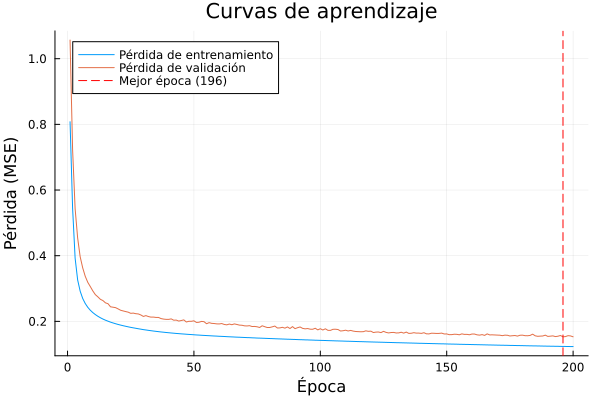

2673-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [10]:
# Split data
global XCgmTrain, XCgmVal, XCgmTest,
        XOtherTrain, XOtherVal, XOtherTest,
        XSubjectTrain, XSubjectVal, XSubjectTest,
        yTrain, yVal, yTest, subjectTest,
        scalerCgm, scalerOther, scalerY = splitData(dfFinal)
            
# Definir arquitectura del modelo
inputDim = 24 * 1 + size(XOtherTrain, 2)  # CGM (flattened) + other features
layerSizes = [inputDim, 64, 32, 16, 1]
println("Arquitectura del modelo: $layerSizes")

# Inicializar y entrenar modelo
global mlpModel = MLPModel(layerSizes, relu, learningRate=1e-3)
trainLosses, valLosses, bestEpoch = train!(
    mlpModel,
    XCgmTrain, XOtherTrain, yTrain,
    XCgmVal, XOtherVal, yVal,
    batchSize=CONFIG["batchSize"],
    epochs=200,
    patience=20
)

# Visualizar curvas de aprendizaje
plotLearningCurves(trainLosses, valLosses, bestEpoch)

# Generar predicciones desnormalizadas para todos los conjuntos
global yPredJuliaTrain = generateDenormalizedPredictions(mlpModel, XCgmTrain, XOtherTrain, scalerY)
global yPredJuliaVal = generateDenormalizedPredictions(mlpModel, XCgmVal, XOtherVal, scalerY)
global yPredJuliaTest = generateDenormalizedPredictions(mlpModel, XCgmTest, XOtherTest, scalerY)

# Generar predicciones basadas en reglas para comparación
global yRule = ruleBasedPrediction(XOtherTest, scalerOther, scalerY)

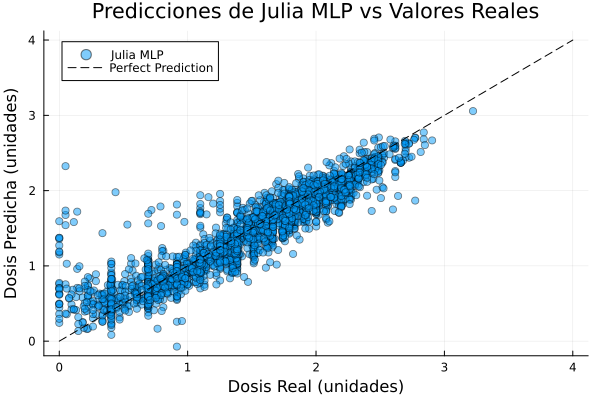

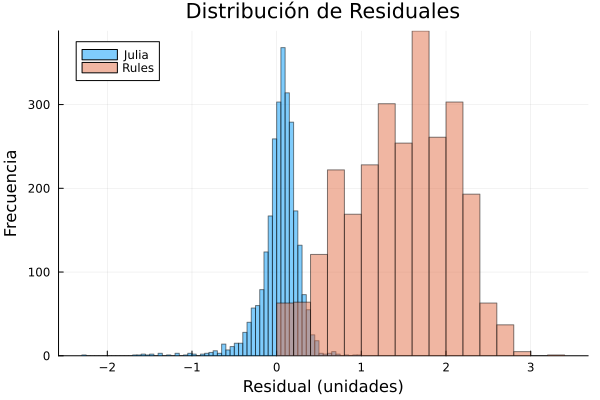

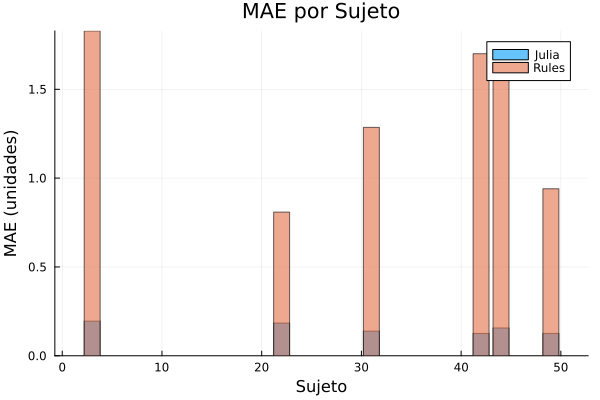

In [11]:
# Métricas para MLP de Julia
maeJulia = mean_absolute_error(ScikitLearn.inverse_transform(scalerY, reshape(yTest, :, 1)), yPredJuliaTest)
rmseJulia = sqrt(mean_squared_error(ScikitLearn.inverse_transform(scalerY, reshape(yTest, :, 1)), yPredJuliaTest))
r2Julia = r2_score(ScikitLearn.inverse_transform(scalerY, reshape(yTest, :, 1)), yPredJuliaTest)
println("Julia MLP Test - MAE: $(round(maeJulia, digits=2)), RMSE: $(round(rmseJulia, digits=2)), R²: $(round(r2Julia, digits=2))")

# Métricas para el modelo basado en reglas
maeRule = mean_absolute_error(ScikitLearn.inverse_transform(scalerY, reshape(yTest, :, 1)), yRule)
rmseRule = sqrt(mean_squared_error(ScikitLearn.inverse_transform(scalerY, reshape(yTest, :, 1)), yRule))
r2Rule = r2_score(ScikitLearn.inverse_transform(scalerY, reshape(yTest, :, 1)), yRule)
println("Rules Test - MAE: $(round(maeRule, digits=2)), RMSE: $(round(rmseRule, digits=2)), R²: $(round(r2Rule, digits=2))")

# Visualizar los resultados
plotEvaluation(yTest, yPredJuliaTest, yRule, subjectTest, scalerY)